In [3]:
import praw
import pandas as pd
import requests
import json
import csv
import re
import string
import numpy as np
from collections import Counter

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

from nltk.stem.lancaster import LancasterStemmer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag

import spacy
import en_core_web_sm
from spacy.lang.en import English




## Data acquisition from Reddit using PSAW
Initially tried using PRAW, but it really limits the number of articles. I then used pushshift API but ran into issues parsing the Json. Finally decided to use PSAW.

### PRAW usage 

In [4]:
# reddit = praw.Reddit(client_id='IpZhTcD6jOpGww', 
#                      client_secret='v6yGS7U8wUzRpmdjFcuz_RYs9uo-Zg', 
#                      user_agent='Emily Lorenzen', 
#                      username='emzilla', 
#                      password='eardrum')

In [5]:
# def get_reddit_articles(subredit):
#     nootropics_sub = reddit.subreddit('nootropics')
#     hot = nootropics_sub.hot(limit=1000)

In [6]:
# def reddit_to_dict(reddit_list):
#     dict = { "title":[],
#                 "subreddit":[],
#                 "score":[], 
#                 "id":[], 
#                 "url":[], 
#                 "comms_num": [], 
#                 "created": [], 
#                 "body":[]}
#     for submission in hot:
#         dict["title"].append(submission.title)
#         dict['subreddit'].append(submission.subreddit)
#         dict["score"].append(submission.score)
#         dict["id"].append(submission.id)
#         dict["url"].append(submission.url)
#         dict["comms_num"].append(submission.num_comments)
#         dict["created"].append(submission.created)
#         dict["body"].append(submission.selftext)
#     return pd.DataFrame(dict)

In [7]:
# df_noo1 = reddit_to_dict(articles)

### Pushshift attempt

In [8]:
# def getPushshiftData(query, after, before, sub):
#     url = 'https://api.pushshift.io/reddit/search/submission/?title='+str(query)+'&size=10&after='+str(after)+'&before='+str(before)+'&subreddit='+str(sub)
#     print(url)
#     r = requests.get(url)
#     data = json.loads(r.text)
#     return data['data']

In [9]:
# def collectSubData(subm):
#     subData = list() #list to store data points
#     title = subm['title']
#     url = subm['url']
#     author = subm['author']
#     sub_id = subm['id']
#     score = subm['score']
#     numComms = subm['num_comments']
#     subData.append((sub_id,title,url,author,score,numComms))
#     subStats[sub_id] = subData
#     return subStats, subData

In [10]:
# def updateSubs_file():
#     upload_count = 0
#     location = "\\Reddit Data\\"
#     print("input filename of submission file, please add .csv")
#     filename = input()
#     file = location + filename
#     with open(file, 'w', newline='', encoding='utf-8') as file: 
#         a = csv.writer(file, delimiter=',')
#         headers = ["Post ID","Title","Url","Author","Score","Publish Date","Total No. of Comments","Permalink","Flair"]
#         a.writerow(headers)
#         for sub in subStats:
#             a.writerow(subStats[sub][0])
#             upload_count+=1
            
#         print(str(upload_count) + " submissions have been uploaded")
# updateSubs_file()

In [11]:
# data = getPushshiftData('', '', '', 'nootropics')
# # Will run until all posts have been gathered 
# # from the 'after' date up until before date
# while len(data) > 0:
#     for submission in data:
#         collectSubData(submission)
#         subCount+=1
#     # Calls getPushshiftData() with the created date of the last submissio
#     after = data[-1]['created_utc']
#     data = getPushshiftData(query, after, before, sub)
    
# print(len(data))

### Next try - PSAW package 
This is essentially a combination of PRAW and pushshift.io

In [12]:
# I grabbed all articles with a score greater than 25. I chose 25 due to processing time. 
from psaw import PushshiftAPI
api = PushshiftAPI()
api_request_generator = api.search_submissions(subreddit='Nootropics', score = ">25")
nootropics_submissions = pd.DataFrame([submission.d_ for submission in api_request_generator])

In [13]:
# Combine the title with the text to create a single document
df_noo = nootropics_submissions[['title', 'selftext']]
df_noo['body'] = df_noo.loc[:, ('title')] + ' ' + df_noo.loc[:, ('selftext')]
df_noo = df_noo.astype(str)
df_noo.body

<ipython-input-13-6a64383a465e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noo['body'] = df_noo.loc[:, ('title')] + ' ' + df_noo.loc[:, ('selftext')]


0       My experience with 1000mg agmatine sulfate ove...
1       Studies Which Show Gamma Band Brainwave Neurof...
2       Striatal dopamine synthesis capacity reflects ...
3       Strange taurine experience: improved sense of ...
4       Vit D with Magnesium The doc prescribed me Vit...
                              ...                        
5797    Can anyone please recommend some homeopathic n...
5798    I'm about to order modafinil for the first tim...
5799    Profound Effects of Combining Choline and Pira...
5800    Where do y'all get your meds? It strikes me th...
5801      My Experience With Various Nootropics [deleted]
Name: body, Length: 5802, dtype: object

## Visualize the words in the articles

In [14]:
#Create a wordclouds to begin to identify words that will not provide a lot of value
def create_wordcloud(wordcloud_series):
    df_text = ' '.join(str(wordcloud_series).lower() for v in wordcloud_series)
    wordcloud = WordCloud(stopwords = None, random_state = 20, background_color = 'white',
                      collocations=True).generate(df_text)
    plt.imshow(wordcloud, interpolation='bilInear')
    plt.axis('off')
    plt.show()
    plt.savefig('wordcloud.png')

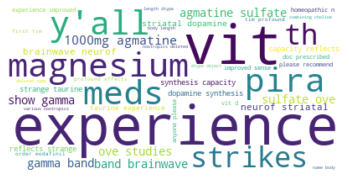

<Figure size 432x288 with 0 Axes>

In [15]:
create_wordcloud(df_noo['body'])
plt.savefig('wordcloud.png')

## Preprocess data to remove words with little value

In [16]:
import contractions
def noo_preprocess(df, column):
    
    apostrophe = lambda x: contractions.fix(x)
    df[column] = df[column].map(apostrophe)
    
    alphanumeric = lambda x: re.sub('[^a-zA-Z]',' ', x)
    lower_case = lambda x: x.lower()
    new_line = lambda x: x.replace('\n', '')
    df[column] = df[column].map(alphanumeric).map(lower_case).map(new_line)
    
    spaces = lambda x: x.replace('  ', ' ')
    df[column] = df[column].map(spaces)

#    Remove specific words that are not informative
    word_list = ['www', 'https', 'http', 'com', 'day' 'yall', 'wh', 'tn', 'im', 've', 'mg', 's']
    for word in word_list:
        remove_word = lambda x: re.sub(r'\b'+word+r'\b', '', x)
        df[column] = df[column].map(remove_word)
        
        
#     stemmer = LancasterStemmer()
#     df[column] = df[column].map(lambda x: [stemmer.stem(y) for y in x.split(' ')])
#     df[column] = df[column].map(lambda x: ' '.join(x))
    df.body.replace('', np.nan, inplace = True) 
    df.dropna(subset = ['body'], inplace = True)
    return df

In [17]:
df_noo_clean = noo_preprocess(df_noo, 'body')
df_noo_clean.body[41]

'l theanine saved my life i just could not pass my driving test no matter what i would always freak out and get too nervous on the day this happened no matter how good my lessons were throughout lockdown i knew my test was coming up the day after it ended i was researching cbd to try and calm myself down but in the uk it was all too expensive or shit i noticed a few gummies contained l theanine so i did lots of research i saw that it emphasised relaxation and focus which is what i needed not even joking took them  days in a row with my coffee drove amazingly in my lesson and completely remained focused my instructor said she would never seen me drive so well the fog was gone eventually i passed my test   it got me through all i focused on was the driving and i did not get anxious  thank you l theanine you god send '

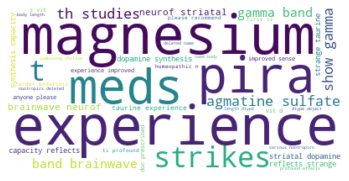

<Figure size 432x288 with 0 Axes>

In [18]:
# See how the preprocess changed the word frequency
create_wordcloud(df_noo_clean['body'])

## Used named entity recognition to identify the nootropics
Initially started using nltk but decided to use spacy for this. Needed to increase max_length to process all characters. 

In [19]:
# def NER_preprocess(df, column):
#     df[column] = df[column].map(lambda x: nltk.word_tokenize(x))
#     df[column] = df[column].map(lambda x: nltk.pos_tag(x))
    
#     pattern = 'NP: {<DT>?<JJ>*<NN>}'
#     cp = nltk.RegexpParser(pattern)
#     cs = df[column].map(lambda x: cp.parse(x))
#     return df

In [20]:
import spacy
from collections import Counter
from spacy.lang.en import English
import en_core_web_sm
nlp = en_core_web_sm.load(max_length = 5000000)

In [21]:
tokens = nlp(''.join(str(df_noo_clean.body.tolist())))
items = [x.text for x in tokens.ents]
Counter(items).most_common(20)

[('first', 782),
 ('one', 727),
 ('two', 405),
 ('daily', 403),
 ('nlm nih', 346),
 ('ncbi nlm nih', 232),
 ('hours', 223),
 ('today', 222),
 ('the day', 221),
 ('adhd', 199),
 ('org', 138),
 ('second', 132),
 ('amazon', 131),
 ('months', 119),
 ('three', 118),
 ('half', 114),
 ('aniracetam', 114),
 ('nih', 108),
 ('years', 108),
 ('night', 100)]

#### It's not clear which label the nootropics will be categorized under, so I tried several below

None of the labels clearly showed the nootropics, in fact all labels showed at least a few nootropics.

In [22]:
def NER_labels(label):
    label_list = []
    for ent in tokens.ents:
        if ent.label_ == label:
            label_list.append(ent.text)

    label_counts = Counter(label_list).most_common(20)
    df_label = pd.DataFrame(label_counts, columns =['text', 'count'])
    return df_label

In [23]:
person_labels = NER_labels('PERSON')
norp_labels = NER_labels('NORP')
org_labels = NER_labels('ORG')
gpe_labels = NER_labels('GPE')
product_labels = NER_labels('PRODUCT')
fac_labels = NER_labels('FAC')
loc_labels = NER_labels('LOC')
loc_labels

,text,count
0,bpc,75
1,europe,16
2,earth,5
3,powder city,5
4,mediterranean,4
5,silicon valley,4
6,west,3
7,pkcs,3
8,africa,3
9,eastern europe,3


## Vectorize the text data

### First I tried good old count vectorize
The results help me decide to remove a few more words in the preprocessing and generally made sense. I moved forward with tfidf, since the topic modeling made more sense. 

In [24]:
def count_vect(df, column):
    cv1 = CountVectorizer(stop_words= 'english')
    df_fit = cv1.fit_transform(df['body'])
    df_fit.toarray()
    df = pd.DataFrame(df_fit.toarray(), columns=cv1.get_feature_names())
    return df, cv1

In [25]:
df_noo_clean_cv, cv1 = count_vect(df_noo_clean, 'body')
# df_noo_clean_cv.sum().sort_values(ascending = False).head(50)

In [26]:
def tfidf(df, column):
    tfidf = TfidfVectorizer(stop_words='english', max_df = 0.9)
    df_noo1_tfidf = tfidf.fit_transform(df_noo_clean['body'])
    df_tfidf = pd.DataFrame(df_noo1_tfidf.toarray(), columns=tfidf.get_feature_names())
    return df_tfidf, tfidf, tfidf.get_feature_names()

In [27]:
df_noo_clean_ti, tfidf, ti_feature_names = tfidf(df_noo_clean, 'body')
sums_tfidf = df_noo_clean_ti.sum()
# sums_tfidf.sort_values(ascending = False).head(50)

In [28]:
#### I'm interested in what the t-SNE will look like, and if there are any clear clusters 

# Dimensionality reduction by topic modeling
I tried using LSA, NMF and LDA. NMF produced the most sensible topics. 

In [29]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

First try LSA. I think three components here is the best

In [30]:
for number in [1,2,3,4,5,6,7,8,9,10]:
    lsa = TruncatedSVD(number)
    lsa.fit_transform(df_noo_clean_ti)
    print(str(display_topics(lsa, ti_feature_names, 10)) + '\n')


Topic  0
nootropics, like, effects, just, day, sleep, feel, brain, caffeine, time
None


Topic  0
nootropics, like, effects, just, day, sleep, feel, brain, caffeine, time

Topic  1
brain, cognitive, memory, pubmed, ncbi, nih, nlm, gov, study, function
None


Topic  0
nootropics, like, effects, just, day, sleep, feel, brain, caffeine, time

Topic  1
brain, cognitive, memory, pubmed, ncbi, nih, nlm, study, gov, improves

Topic  2
nootropics, nootropic, brain, drugs, new, people, best, piracetam, reddit, guide
None


Topic  0
nootropics, like, effects, just, day, sleep, feel, brain, caffeine, time

Topic  1
brain, cognitive, memory, pubmed, ncbi, nih, nlm, study, gov, improves

Topic  2
nootropics, nootropic, brain, new, best, drugs, people, reddit, guide, research

Topic  3
caffeine, ncbi, nlm, theanine, gov, nih, pubmed, pmc, effects, coffee
None


Topic  0
nootropics, like, effects, just, day, sleep, feel, brain, caffeine, time

Topic  1
brain, cognitive, memory, pubmed, ncbi, nih, nl

Now I will try NMF. I got very similar results to LSA, best with 3 components. 

In [31]:
for number in [1,2,3,4,5,6,7,8,9,10]:
    nmf = NMF(number)
    nmf.fit_transform(df_noo_clean_ti)
    print('components' + str(number) + str(display_topics(nmf, ti_feature_names, 10)) + '\n')

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
nootropics, like, effects, just, day, sleep, feel, brain, caffeine, time
components1None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
nootropics, like, just, day, feel, sleep, caffeine, time, taking, anxiety

Topic  1
brain, cognitive, memory, study, pubmed, ncbi, nih, nlm, gov, effects
components2None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
day, like, feel, just, sleep, caffeine, taking, anxiety, time, theanine

Topic  1
brain, cognitive, memory, study, pubmed, ncbi, nih, nlm, gov, effects

Topic  2
nootropics, nootropic, best, people, use, new, drugs, stack, guys, reddit
components3None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
day, like, feel, just, caffeine, sleep, taking, anxiety, time, theanine

Topic  1
brain, cognitive, memory, study, function, effects, performance, exercise, healthy, improves

Topic  2
nootropics, nootropic, best, people, use, drugs, new, stack, reddit, guys

Topic  3
ncbi, nih, nlm, gov, pubmed, pmc, dopamine, articles, receptor, receptors
components4None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, day, feel, just, sleep, taking, anxiety, time, did, really

Topic  1
brain, cognitive, memory, study, function, effects, performance, exercise, improves, healthy

Topic  2
nootropics, nootropic, best, people, use, new, drugs, stack, guys, reddit

Topic  3
ncbi, nih, nlm, gov, pubmed, pmc, dopamine, articles, receptor, receptors

Topic  4
caffeine, theanine, coffee, effects, tea, drink, pills, green, does, combo
components5None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, just, day, feel, anxiety, taking, time, did, really, effects

Topic  1
brain, cognitive, memory, study, function, effects, performance, healthy, controlled, improves

Topic  2
nootropics, nootropic, best, use, people, drugs, new, stack, reddit, guys

Topic  3
ncbi, nih, nlm, gov, pubmed, pmc, dopamine, articles, receptor, receptors

Topic  4
caffeine, theanine, coffee, tea, effects, drink, pills, green, does, drinking

Topic  5
sleep, deprivation, melatonin, night, hours, quality, modafinil, wake, asleep, rem
components6None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, just, day, feel, anxiety, taking, time, did, really, effects

Topic  1
brain, cognitive, memory, study, function, effects, performance, healthy, controlled, improves

Topic  2
nootropics, nootropic, best, use, people, drugs, new, stack, reddit, guys

Topic  3
ncbi, nih, nlm, gov, pubmed, pmc, dopamine, articles, receptor, receptors

Topic  4
caffeine, theanine, coffee, tea, effects, drink, pills, green, does, drinking

Topic  5
sleep, deprivation, melatonin, night, hours, quality, modafinil, wake, asleep, rem

Topic  6
nan, gut, bacteria, microbiome, microbes, health, probiotics, diet, amp, parkinson
components7None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, just, day, feel, anxiety, taking, time, did, really, effects

Topic  1
cognitive, memory, controlled, trial, effects, study, randomized, adults, double, blind

Topic  2
nootropics, nootropic, best, use, people, new, drugs, stack, reddit, guys

Topic  3
ncbi, nih, nlm, gov, pubmed, pmc, dopamine, articles, receptor, receptors

Topic  4
caffeine, theanine, coffee, tea, effects, drink, pills, does, green, drinking

Topic  5
sleep, deprivation, melatonin, night, hours, quality, wake, modafinil, asleep, exercise

Topic  6
nan, magnesium, vitamin, deficiency, supplementation, depression, threonate, citrate, glycinate, supplement

Topic  7
brain, exercise, gut, health, fog, study, does, diet, human, cells
components8None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, just, day, feel, anxiety, taking, time, did, really, effects

Topic  1
brain, exercise, gut, study, health, fog, does, diet, human, cells

Topic  2
nootropics, nootropic, best, use, people, drugs, new, stack, reddit, guys

Topic  3
ncbi, nih, nlm, gov, pubmed, pmc, dopamine, articles, receptor, receptors

Topic  4
cognitive, controlled, trial, randomized, blind, double, placebo, study, adults, function

Topic  5
sleep, deprivation, melatonin, hours, night, quality, wake, modafinil, asleep, exercise

Topic  6
nan, nicotine, nootropic, gum, experiment, favorite, harmful, increases, cognition, smoking

Topic  7
caffeine, theanine, coffee, tea, effects, drink, pills, does, green, drinking

Topic  8
memory, working, learning, mice, term, improves, hippocampal, neurogenesis, enhances, long
components9None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, just, day, feel, time, taking, did, really, anxiety, effects

Topic  1
memory, cognitive, effects, function, performance, improves, term, mice, healthy, working

Topic  2
nootropics, nootropic, best, use, people, new, drugs, stack, reddit, guide

Topic  3
ncbi, nih, nlm, gov, pubmed, pmc, dopamine, articles, receptors, receptor

Topic  4
controlled, trial, placebo, blind, double, randomized, study, adults, randomised, supplementation

Topic  5
sleep, deprivation, melatonin, night, hours, quality, modafinil, wake, asleep, exercise

Topic  6
nan, gut, bacteria, microbiome, disease, alzheimer, probiotics, microbes, parkinson, link

Topic  7
caffeine, theanine, coffee, tea, effects, drink, pills, does, green, drinking

Topic  8
brain, gut, exercise, study, health, fog, does, human, cells, damage

Topic  9
magnesium, vitamin, depression, anxiety, deficiency, supplementation, treatment, threonate, taking, citrate
components10None



Finally I tried LDA. The topics were super different, and really interesting. I'd like to explore this more, but the topics for NMF were more obvious and easier to work with. 

In [32]:
for number in [1,2,3,4,5]:
    lda = LatentDirichletAllocation(number)
    lda.fit_transform(df_noo_clean_ti)
    print('components' + str(number) + str(display_topics(lda, ti_feature_names, 10)) + '\n')




Topic  0
brain, nootropics, effects, like, just, cognitive, sleep, caffeine, memory, day
components1None


Topic  0
nootropics, brain, effects, like, just, sleep, caffeine, day, anxiety, cognitive

Topic  1
memory, hippocampal, alzheimer, improves, adult, enhances, adults, cognitive, brain, mice
components2None


Topic  0
nan, induced, mice, hippocampal, adult, model, enhances, systematic, expression, neurotrophic

Topic  1
brain, alzheimer, pubmed, disease, cognitive, nih, mice, ncbi, nlm, microdosing

Topic  2
nootropics, like, brain, effects, just, sleep, caffeine, day, feel, anxiety
components3None


Topic  0
nootropics, like, brain, effects, just, sleep, caffeine, day, nootropic, anxiety

Topic  1
pubmed, ncbi, nlm, gov, nih, systematic, brain, alzheimer, pmc, aging

Topic  2
brain, memory, induced, cognitive, improves, mice, cortex, alzheimer, disease, function

Topic  3
nan, controlled, hippocampal, neurogenesis, randomized, adult, memory, trial, gut, mice
components4None


Top

In [33]:
lda= LatentDirichletAllocation(n_components=3)
df_topic_lda = lda.fit_transform(df_noo_clean_ti)
lda_topics_by_post = pd.DataFrame(df_topic_lda, index = df_noo_clean.body)
lda_topics_by_post.head(20)

,0,1,2
body,,,
my experience with agmatine sulfate over the last few days i have been in a state of mild moderate depression and anxiety for the past couple of weeks and not much has enabled me to think and function normally apart from agmatine literally within an hour of taking it i felt better than i have in many weeks one of the most prominent effects i immediately noticed was the clarity of mind i did not have to think about anything in particular my mind just kind of rested if i was not trying to focus on something to me this effect was fucking incredible especially because the response i felt was also associated with a feeling of wellbeing my adhedonia was almost immediately reduced when the effects kicked in i would say this specific effect is particularly effective if your mental distress was caused by something specific which it was in my case although it for sure works in other circumstances as well just based on anecdotes i have read it allowed me quiet my annoyingly loud mind and just enjoy the moment in my limited knowledge of physiology i would assume that this subjective mind clarity effect is a result of the nmda antagonism that agmatine is implicated in another effect i felt was the calm body effect i assume this is caused by the no modulation and beta endorphin release another antidepressant mode of action i would say if you are struggling with anxiety also look into propranolol i definitely think the mind body feedback loop for anxiety is massively powerful and not something to gloss over when trying to understand your anxiety and in my opinion the anti anxiety effects of agmantine are partially due to this bp heart rate effect i take about g of agmatine sulfate on an empty stomach or with carbs but definitely not with protein and i start to notice effects within minutes also drinking coffee after you take agmatine is an experience on its own i rambled a lot but needless to say i will be continuing to take this supplement and analyzing my response just because its been so goddamn effective,0.032636,0.032629,0.934736
studies which show gamma band brainwave neurofeedback increase intelligence clear the brain of alzheimer plaques and numerous other benefits study article dates gamma neurofeedback increases intelligence pubmed ncbi nlm nih gov neural synchronization in the gamma band has been associated with feature binding and intelligence using neurofeedback we aimed at changing the power of the gamma band and investigated whether these changes would influence behavioral measures of feature binding and intelligence the results show that people are indeed able to alter the power in the gamma band if provided with neurofeedback moreover the increase of gamma band power was related to a decrease of binding costs and an increase in intelligence suggesting that the control of feature binding and intelligence share a common underlying mechanism gamma brainwaves can clear beta amyloid plaques seen in alzheimer patients and improve memory nia nih gov news harnessing gamma brain waves clear alzheimers proteins could stimulate gamma waves which not only reduced levels of beta amyloid plaques in the brain a hallmark of the alzheimer but boosted the clearance of harmful debris by microglia cells this finding published online december in nature nia nih gov news noninvasive brain wave treatment reduces alzheimers pathology improves memory mice news mit edu brain wave stimulation improve alzheimers buddhist monks with hours meditation experience show extremely high amplitude gamma waves during meditation pnas org content long term meditators self induce high amplitude gamma synchrony during mental practice brief bursts of high amplitude gamma band activity seen before an aha eureka or epiphany moment pubmed ncbi nlm nih gov posterior beta and anterior gamma oscillations predict cognitive insight abstract pioneering neuroimaging studies on insight have revealed neural correlates of the emotional aha component of the insight p

In [35]:
nmf_model = NMF(3)
df_tfidf_topic = nmf_model.fit_transform(df_noo_clean_ti)
comp_list = []
for i in range(3):
    comp_list.append('component_'+str(i))
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = comp_list,
             columns = ti_feature_names)
display_topics(nmf_model, ti_feature_names, 12)
word_topic_matrix_df = pd.DataFrame(nmf_model.components_, columns=ti_feature_names).T.add_prefix('topic_')
word_topic_matrix_df['body'] = df_noo_clean['body']

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
day, like, feel, just, sleep, caffeine, taking, anxiety, time, theanine, effects, did

Topic  1
brain, cognitive, memory, study, pubmed, ncbi, nih, nlm, gov, effects, function, dopamine

Topic  2
nootropics, nootropic, best, people, use, new, drugs, stack, guys, reddit, know, guide


In [36]:
topics_by_post = pd.DataFrame(df_tfidf_topic, columns = ['experiences', 'physiology', 'advice'])
topics_by_post['main_topic'] = topics_by_post.idxmax(axis=1)
topics_by_post.index = df_noo_clean['body']
topics_by_post[(topics_by_post['main_topic']== 'experiences')].head()
topics_by_post.head()

,experiences,physiology,advice,main_topic
body,,,,
my experience with agmatine sulfate over the last few days i have been in a state of mild moderate depression and anxiety for the past couple of weeks and not much has enabled me to think and function normally apart from agmatine literally within an hour of taking it i felt better than i have in many weeks one of the most prominent effects i immediately noticed was the clarity of mind i did not have to think about anything in particular my mind just kind of rested if i was not trying to focus on something to me this effect was fucking incredible especially because the response i felt was also associated with a feeling of wellbeing my adhedonia was almost immediately reduced when the effects kicked in i would say this specific effect is particularly effective if your mental distress was caused by something specific which it was in my case although it for sure works in other circumstances as well just based on anecdotes i have read it allowed me quiet my annoyingly loud mind and just enjoy the moment in my limited knowledge of physiology i would assume that this subjective mind clarity effect is a result of the nmda antagonism that agmatine is implicated in another effect i felt was the calm body effect i assume this is caused by the no modulation and beta endorphin release another antidepressant mode of action i would say if you are struggling with anxiety also look into propranolol i definitely think the mind body feedback loop for anxiety is massively powerful and not something to gloss over when trying to understand your anxiety and in my opinion the anti anxiety effects of agmantine are partially due to this bp heart rate effect i take about g of agmatine sulfate on an empty stomach or with carbs but definitely not with protein and i start to notice effects within minutes also drinking coffee after you take agmatine is an experience on its own i rambled a lot but needless to say i will be continuing to take this supplement and analyzing my response just because its been so goddamn effective,0.082390,0.016319,0.000000,experiences
studies which show gamma band brainwave neurofeedback increase intelligence clear the brain of alzheimer plaques and numerous other benefits study article dates gamma neurofeedback increases intelligence pubmed ncbi nlm nih gov neural synchronization in the gamma band has been associated with feature binding and intelligence using neurofeedback we aimed at changing the power of the gamma band and investigated whether these changes would influence behavioral measures of feature binding and intelligence the results show that people are indeed able to alter the power in the gamma band if provided with neurofeedback moreover the increase of gamma band power was related to a decrease of binding costs and an increase in intelligence suggesting that the control of feature binding and intelligence share a common underlying mechanism gamma brainwaves can clear beta amyloid plaques seen in alzheimer patients and improve memory nia nih gov news harnessing gamma brain waves clear alzheimers proteins could stimulate gamma waves which not only reduced levels of beta amyloid plaques in the brain a hallmark of the alzheimer but boosted the clearance of harmful debris by microglia cells this finding published online december in nature nia nih gov news noninvasive brain wave treatment reduces alzheimers pathology improves memory mice news mit edu brain wave stimulation improve alzheimers buddhist monks with hours meditation experience show extremely high amplitude gamma waves during meditation pnas org content long term meditators self induce high amplitude gamma synchrony during mental practice brief bursts of high amplitude gamma band activity seen before an aha eureka or epiphany moment pubmed ncbi nlm nih gov posterior beta and anterior gamma oscillations predict cognitive insight abstract pioneering neuroimaging studies on insight have revealed neural correlates

# Clustering

## T-SNE
Interesting division of the topic spaces, however does not provide clustering assignments

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


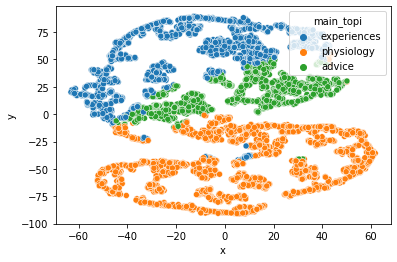

In [37]:
ss = StandardScaler()
tsne_model = TSNE(n_components=2, random_state=22, metric = 'cosine')
tsne_coords = tsne_model.fit_transform(ss.fit_transform(ss.fit_transform(topics_by_post[['experiences', 'physiology', 'advice']])))
viz_df = pd.DataFrame(tsne_coords, columns = ['x', 'y'])
viz_df.index = topics_by_post.index
viz_df['main_topi'] = topics_by_post['main_topic']
sns.scatterplot(data = viz_df, x='x', y='y', hue = 'main_topi')
plt.savefig('tsne.png')

## K-Means
This is a mess of a dataset, lol. 

In [38]:
#First plot the dataset
from sklearn.cluster import KMeans
ss = StandardScaler()
topics_by_post_scaled = ss.fit_transform(topics_by_post[['experiences', 'physiology', 'advice']])

<ipython-input-39-e3647a8877af>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


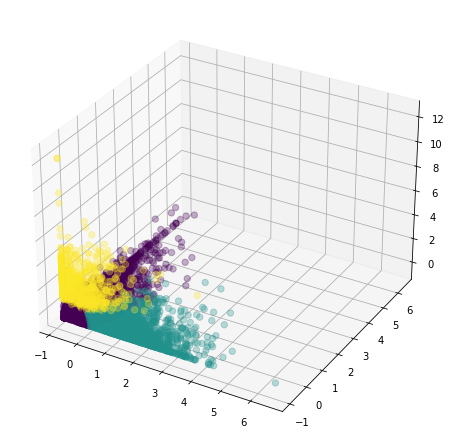

In [39]:
km = KMeans(n_clusters = 3, max_iter = 10000, random_state = 1)
km_labels = km.fit_predict(topics_by_post_scaled)

from mpl_toolkits.mplot3d import Axes3D

x = topics_by_post_scaled[:, 0]
y = topics_by_post_scaled[:, 1]
z = topics_by_post_scaled[:, 2]

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

sc = ax.scatter(x, y, z, s=40, marker='o', alpha=.3, c=km_labels)


Kmeans didn't do a great job with this. My data is super weird. I'm going to go back to the topic modeling and focus just on the 'experience' posts. 

In [40]:
# Create an experiences only dataset
df_noo_clean_ti.index = topics_by_post.index
df_noo_clean_ti['main_topic'] = topics_by_post['main_topic']
df_experiences = df_noo_clean_ti[df_noo_clean_ti.main_topic == 'experiences']

# df_experiences.drop('major_topic', axis = 1, inplace = True)
df_experiences.drop('main_topic', axis = 1, inplace = True)
df_experiences.head()

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,aa,aaaaaaaaa,aaad,aab,aac,aacb,aacrjournals,aacv,aadc,aafp,...,zutv,zv,zw,zwei,zxyq,zybrp,zyoq,zyprexa,zyrtec,zz
body,,,,,,,,,,,,,,,,,,,,,
my experience with agmatine sulfate over the last few days i have been in a state of mild moderate depression and anxiety for the past couple of weeks and not much has enabled me to think and function normally apart from agmatine literally within an hour of taking it i felt better than i have in many weeks one of the most prominent effects i immediately noticed was the clarity of mind i did not have to think about anything in particular my mind just kind of rested if i was not trying to focus on something to me this effect was fucking incredible especially because the response i felt was also associated with a feeling of wellbeing my adhedonia was almost immediately reduced when the effects kicked in i would say this specific effect is particularly effective if your mental distress was caused by something specific which it was in my case although it for sure works in other circumstances as well just based on anecdotes i have read it allowed me quiet my annoyingly loud mind and just enjoy the moment in my limited knowledge of physiology i would assume that this subjective mind clarity effect is a result of the nmda antagonism that agmatine is implicated in another effect i felt was the calm body effect i assume this is caused by the no modulation and beta endorphin release another antidepressant mode of action i would say if you are struggling with anxiety also look into propranolol i definitely think the mind body feedback loop for anxiety is massively powerful and not something to gloss over when trying to understand your anxiety and in my opinion the anti anxiety effects of agmantine are partially due to this bp heart rate effect i take about g of agmatine sulfate on an empty stomach or with carbs but definitely not with protein and i start to notice effects within minutes also drinking coffee after you take agmatine is an experience on its own i rambled a lot but needless to say i will be continuing to take this supplement and analyzing my response just because its been so goddamn effective,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
strange taurine experience improved sense of smell and taste i took taurine for the first time about an hour ago and right now i am smelling things i have never smelled before but i am in my own house around all the same things i also tasted my cbd tincture the same one i have every night and it is taste is wayyy stronger i normally do not have a good sense of smell or taste so this is wild why would this be happening i definitely do not think it is placebo as my nose is actually picking up on things it has not before the difference is not subtle,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vit d with magnesium the doc prescribed me vit d as i have low amounts i take it around pm but i also learned on the internet that i need to take magnesium as well in order to make vit d more effective which one should i take before vit d or and should i take not prescribed everyday that i take d prescribed,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
getting great results from my multivitamins for mood brain fog and libido but i am not sure what does the trick currently taking life extension two per day amazon life extension potency multi vitamin supplement dp b kcz cdw ref sr dchild amp keywords lef two per day amp qid amp sr and actually taking only one capsule every two day so of the dose and i am feeling much better better libido less brain fog better mood and drive the thing is i have taken other methylated b complex before and never actually felt a real difference since i was already taking methylated b p p methyl folate zinc vitamin d vitamin k magnesium i have to rule these out i eat plenty of seaweed so it is not iodine right off the bat i was t

In [41]:
for number in [5, 10,15,20,25]:
    nmf = NMF(number)
    nmf.fit_transform(df_experiences)
    print('components' + str(number) + str(display_topics(nmf, ti_feature_names, 10)) + '\n')

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, day, feel, just, time, anxiety, taking, did, effects, really

Topic  1
nan, modafinil, armodafinil, price, adrafinil, chart, adderall, updated, genotyping, comparison

Topic  2
caffeine, coffee, drink, pills, drinking, does, energy, day, makes, cup

Topic  3
sleep, night, hours, melatonin, deprivation, quality, wake, asleep, day, magnesium

Topic  4
theanine, tea, taking, effects, green, anxiety, combo, does, use, ashwagandha
components5None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
like, just, feel, day, did, really, time, felt, life, work

Topic  1
nan, phenibut, soviet, fasoracetam, mixing, gaba, tolerance, pamphlet, memantine, baclofen

Topic  2
caffeine, coffee, drink, pills, drinking, energy, does, cup, makes, tolerance

Topic  3
sleep, melatonin, hours, night, deprivation, quality, wake, asleep, deep, bed

Topic  4
theanine, tea, green, taking, effects, combo, does, like, caffeine, use

Topic  5
magnesium, taking, vitamin, citrate, glycinate, supplements, supplement, threonate, fish, oil

Topic  6
effects, piracetam, long, term, noopept, taking, use, experience, daily, mane

Topic  7
anxiety, social, depression, phenibut, tried, gaba, does, oil, taking, help

Topic  8
modafinil, armodafinil, price, adrafinil, adderall, week, chart, does, taking, work

Topic  9
ashwagandha, long, thyroid, ksm, term, rhodiola, use, day, taken, taking
components10None



/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
anxiety, social, depression, phenibut, tried, gaba, oil, help, taking, cbd

Topic  1
nan, amp, nbsp, sr, build, mood, amazon, rhodiola, qid, ref

Topic  2
caffeine, tolerance, pills, theacrine, energy, combo, bulk, affect, powder, nicotine

Topic  3
sleep, melatonin, deprivation, night, hours, quality, wake, asleep, deep, rem

Topic  4
theanine, tea, green, taking, effects, combo, does, try, dosage, like

Topic  5
magnesium, taking, vitamin, citrate, glycinate, supplements, threonate, supplement, vitamins, fish

Topic  6
effects, long, term, use, daily, experience, negative, mood, benefits, tolerance

Topic  7
modafinil, armodafinil, price, adrafinil, adderall, chart, does, week, taking, drug

Topic  8
coffee, drink, drinking, tea, does, cup, pills, oil, liver, cups

Topic  9
ashwagandha, thyroid, ksm, rhodiola, taking, taken, cortisol, extract, long, adaptogen

Topic  10
day, days, hours, work, week, night, felt, taking, took, morning

Topic  11
mane, lion, lions, taking, ex

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
just, like, did, time, really, know, things, think, life, got

Topic  1
nan, melatonin, know, wanted, dose, night, label, bottle, mcg, bones

Topic  2
caffeine, pills, tolerance, theacrine, combo, effects, energy, bulk, affect, alternative

Topic  3
sleep, melatonin, deprivation, night, hours, quality, wake, asleep, deep, rem

Topic  4
theanine, taking, effects, combo, does, try, dosage, like, use, stress

Topic  5
magnesium, taking, vitamin, citrate, glycinate, threonate, supplement, oxide, form, vitamins

Topic  6
long, term, use, effects, daily, time, cycle, short, benefits, negative

Topic  7
anxiety, social, depression, gaba, tried, taking, help, anti, tyrosine, started

Topic  8
coffee, drink, drinking, cup, pills, liver, makes, cirrhosis, cups, does

Topic  9
ashwagandha, thyroid, ksm, rhodiola, taking, taken, cortisol, extract, adaptogen, ht

Topic  10
day, days, hours, night, work, week, morning, felt, taking, bed

Topic  11
mane, lion, lions, taking, experience, mus

/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
just, like, did, time, really, life, things, know, think, people

Topic  1
nan, adderall, bpc, charts, comparison, focus, mixing, rise, adhd, vs

Topic  2
caffeine, pills, tolerance, theacrine, combo, bulk, effects, alternative, powder, withdrawal

Topic  3
sleep, deprivation, hours, quality, night, wake, deep, asleep, rem, sleeping

Topic  4
theanine, effects, combo, try, dosage, like, use, calm, does, combination

Topic  5
magnesium, vitamin, citrate, glycinate, threonate, supplement, oxide, form, supplements, vitamins

Topic  6
long, term, effects, use, daily, time, cycle, negative, short, benefits

Topic  7
anxiety, social, depression, gaba, tried, anti, help, best, cbd, thing

Topic  8
coffee, drink, drinking, cup, pills, liver, makes, cirrhosis, cups, focus

Topic  9
ashwagandha, thyroid, ksm, rhodiola, taken, extract, cortisol, adaptogen, ht, powder

Topic  10
day, days, work, hours, night, week, felt, morning, hour, bed

Topic  11
mane, lion, lions, experience, mushro

Now I am starting to see individual nootropics showing up in the topics, which is kind of cool. I'm going to go ahead with 20 components. 

In [42]:
nmf = NMF(20)
df_experience_nmf = nmf.fit_transform(df_experiences)
nmf_experiences_by_post = pd.DataFrame(df_experience_nmf, index = df_experiences.index)
ss = StandardScaler()
experiences_by_post_scaled = ss.fit_transform(nmf_experiences_by_post)


/Applications/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


<ipython-input-43-41a663632bd5>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fig.add_axes(ax)


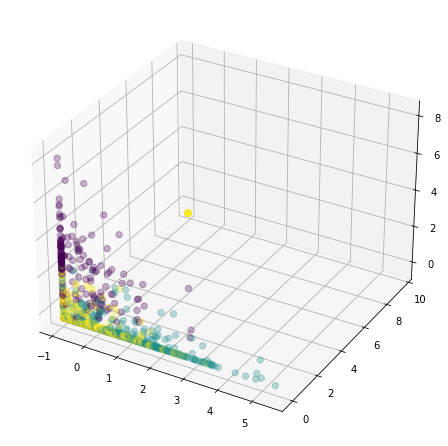

In [43]:
km = KMeans(n_clusters = 3, max_iter = 10000, random_state = 1)
km_labels = km.fit_predict(experiences_by_post_scaled)

from mpl_toolkits.mplot3d import Axes3D

x = experiences_by_post_scaled[:, 0]
y = experiences_by_post_scaled[:, 1]
z = experiences_by_post_scaled[:, 2]

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
fig.add_axes(ax)

sc = ax.scatter(x, y, z, s=40, marker='o', alpha=.3, c=km_labels)
plt.savefig('kmeans.png')

This is still completely unclusterable.

### CoRex
I'm finally going to try CoRex and use anchor words to focus on certain nootropics and the experiences. 

In [44]:
df_noo_clean.index = topics_by_post.index
df_noo_clean['main_topic'] = topics_by_post['main_topic']
df_experiences = df_noo_clean[df_noo_clean.main_topic == 'experiences']


In [45]:
vectorizer = CountVectorizer(stop_words='english', token_pattern="\\b[a-z][a-z]+\\b",
                             binary=True)

doc_word = vectorizer.fit_transform(df_experiences.body)

In [46]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

In [47]:
words = list(np.asarray(vectorizer.get_feature_names()))
topic_model = ct.Corex(n_hidden=6, words=words, seed=1)
topic_model.fit(doc_word, words=words, docs=df_experiences.body)

In [48]:
topic_model.get_top_docs(topic=4, n_docs=2)

[('my experience with    agmatine sulfate over the last few days i have been in a state of mild moderate depression and anxiety for the past couple of weeks and not much has enabled me to think and function normally apart from agmatine literally within an hour of taking it i felt better than i have in many weeks  one of the most prominent effects i immediately noticed was the clarity of mind i did not have to think about anything in particular my mind just kind of rested if i was not trying to focus on something to me this effect was fucking incredible especially because the response i felt was also associated with a feeling of wellbeing my adhedonia was almost immediately reduced when the effects kicked in  i would say this specific effect is particularly effective if your mental distress was caused by something specific which it was in my case although it for sure works in other circumstances as well just based on anecdotes i have read  it allowed me quiet my annoyingly loud mind and

In [49]:
predictions = pd.DataFrame(topic_model.predict(doc_word), columns=['topic'+str(i) for i in range(6)])
predictions

,topic0,topic1,topic2,topic3,topic4,topic5
0,True,False,True,False,True,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,True,False,False,False,True,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
1940,False,False,False,False,False,False
1941,False,False,True,True,False,False
1942,False,False,False,False,False,False
1943,False,False,False,False,False,False


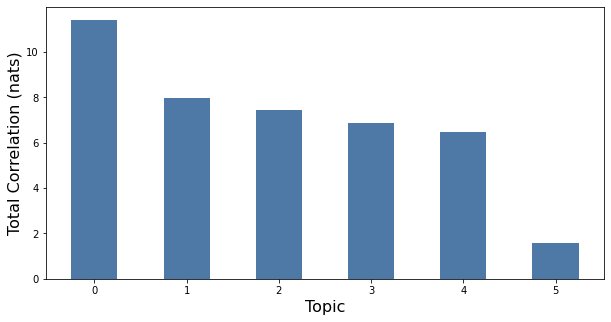

In [50]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [ ]:
topic_model = ct.Corex(n_hidden=15, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model.fit(doc_word, words=words, docs=df_experiences.body, 
                anchors=[['caffeine'], 
                         ['phenibut'], 
                         ['piracetam'], 
                         ['lion', 'mane'],
                         ['ashwagandha'], 
                         ['noopept'],
                         ['theanine'],
                         ['bacopa'],
                         ['phenylpiracetam'],
                         ['modafinil'],
                         ['creatine'],
                         ['kratom'],
                         ['oxiracetam'],
                         ['taurine'],
                         ['methylene', 'blue']], anchor_strength=10)

# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

In [ ]:
caffeine = topic_model.get_top_docs(topic=0, n_docs=100)
phenibut = topic_model.get_top_docs(topic=1, n_docs=100)
piracetam = topic_model.get_top_docs(topic=2, n_docs=100)
lion_mane = topic_model.get_top_docs(topic=3, n_docs=100)
ashwagandha = topic_model.get_top_docs(topic=4, n_docs=100)
noopept = topic_model.get_top_docs(topic=5, n_docs=100)
theanine = topic_model.get_top_docs(topic=6, n_docs=100)
bacopa = topic_model.get_top_docs(topic=7, n_docs=100)
phenylpiracetam = topic_model.get_top_docs(topic=8, n_docs=100)
modafinil = topic_model.get_top_docs(topic=9, n_docs=100)
creatine = topic_model.get_top_docs(topic=10, n_docs=100)
kratom = topic_model.get_top_docs(topic=11, n_docs=100)
oxiracetam = topic_model.get_top_docs(topic=12, n_docs=100)
taurine = topic_model.get_top_docs(topic=13, n_docs=100)
methylene_blue = topic_model.get_top_docs(topic=14, n_docs=100)

In [ ]:
methylene_blue[0]

In [ ]:
from textblob import TextBlob

def get_sentiment(topic_list):
    pol = lambda x: TextBlob(x).sentiment.polarity
    sub = lambda x: TextBlob(x).sentiment.subjectivity
    pol_list = [pol(x[0]) for x in topic_list]
    sub_list = [sub(x[0]) for x in topic_list]
    sentiment_dict = {}
    sentiment_dict['polarity'] = (np.mean(pol_list))
    sentiment_dict['subjectivity'] = (np.mean(sub_list))
    
    return sentiment_dict

In [ ]:
from varname import nameof
df_sentiment = pd.DataFrame(columns = ('polarity', 'subjectivity')) 
topic_list = ['caffeine', 'phenibut', 'bacopa', 'piracetam', 'lion_mane', 'ashwagandha', 'noopept', 'theanine', 'phenylpiracetam', 'modafinil', 'creatine', 'kratom', 'oxiracetam', 'taurine', 'methylene_blue']
for topic in topic_list:
    sentiment_dict = get_sentiment(locals()[topic])
    df_sentiment.loc[topic] = [sentiment_dict['polarity'], sentiment_dict['subjectivity']]
df_sentiment

Bummer

### Try Vader as a last attempt

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
def get_vader_mean(topic):
    final_dict = {}
    list_dicts = []
    for document in topic:
        sentiment_dict = sid.polarity_scores(document[0])
        list_dicts.append(sentiment_dict)
    final_dict['negative'] = np.mean([d['neg'] for d in list_dicts])
    final_dict['neutral'] = np.mean([d['neu'] for d in list_dicts])
    final_dict['positive'] = np.mean([d['pos'] for d in list_dicts])
    final_dict['compound'] = np.mean([d['compound'] for d in list_dicts])
    return final_dict

In [ ]:
def get_vader_std(topic):
    final_dict = {}
    list_dicts = []
    for document in topic:
        sentiment_dict = sid.polarity_scores(document[0])
        list_dicts.append(sentiment_dict)
    final_dict['negative'] = np.std([d['neg'] for d in list_dicts])
    final_dict['neutral'] = np.std([d['neu'] for d in list_dicts])
    final_dict['positive'] = np.std([d['pos'] for d in list_dicts])
    final_dict['compound'] = np.std([d['compound'] for d in list_dicts])
    return final_dict

In [ ]:
df_vader_mean = pd.DataFrame(columns = ('negative', 'neutral', 'positive', 'compound')) 
topic_list = ['caffeine', 'phenibut', 'bacopa', 'piracetam', 'lion_mane', 'ashwagandha', 'noopept', 'theanine', 'phenylpiracetam', 'modafinil', 'creatine', 'kratom', 'oxiracetam', 'taurine', 'methylene_blue']
for topic in topic_list:
    sentiment_dict = get_vader_mean(locals()[topic])
    df_vader_mean.loc[topic] = [sentiment_dict['negative'], sentiment_dict['neutral'], sentiment_dict['positive'], sentiment_dict['compound']]


In [ ]:
df_vader_mean

In [ ]:
df_vader_std = pd.DataFrame(columns = ('negative', 'neutral', 'positive', 'compound')) 
topic_list = ['caffeine', 'phenibut', 'bacopa', 'piracetam', 'lion_mane', 'ashwagandha', 'noopept', 'theanine', 'phenylpiracetam', 'modafinil', 'creatine', 'kratom', 'oxiracetam', 'taurine', 'methylene_blue']
for topic in topic_list:
    sentiment_dict = get_vader_std(locals()[topic])

    df_vader_std.loc[topic] = [sentiment_dict['negative'], sentiment_dict['neutral'], sentiment_dict['positive'], sentiment_dict['compound']]
df_vader_std

In [ ]:
df_vader_mean.sort_values('positive', inplace = True, ascending = False)
plt.figure(figsize = [10,5])
sns.barplot(x = df_vader_mean.index, y = df_vader_mean.negative, color = 'darkslateblue')
plt.xticks(size = 12)
plt.xlabel('Nootropic Name', size = 15)
plt.ylabel('Negative Score', size = 15)
plt.xticks(rotation=45) 
plt.savefig('negative.png', bbox_inches = 'tight');

In [ ]:
# df_vader_mean.drop(columns = 'neutral', inplace = True)
vader_rank = df_vader_mean.rank(ascending = False)
vader_rank.negative = df_vader_mean.negative.rank(ascending = True)
vader_rank = vader_rank[['compound', 'positive', 'negative']]
vader_rank.sort_values('compound', inplace = True)
plt.figure(figsize = [9,7])
sns.heatmap(vader_rank.transpose(), annot = True, square = True, cbar = False, cmap = 'viridis_r')
plt.xlabel('Nootropic', size = 14)
plt.xticks(rotation = 45)
plt.savefig('heatmap.png')

In [ ]:
df_vader_.sort_values('compound', ascending = False).plot(y = 'compound', kind = 'bar')
plt.xticks(rotation = 45)
plt.figure(figsize = [15,30]); 

In [ ]:
df_vader_std.sort_values('positive', ascending = False).plot(y = ['negative', 'positive'], kind = 'bar')